# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [52]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#print(os.getcwd())

In [53]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 125000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (125000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [54]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [55]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [56]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [57]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [58]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [59]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [60]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(107311, 10)

In [61]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

85.8488

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [62]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [63]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [64]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()
y=final['Score']
#print(y)

(107309, 10)


#As data is imbalanced I selected 5k positive and 5k negative samples in next cell

#Displayed labels of dataset which shows positive and negative samples are seperated so we need to shuffle these

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [65]:
# printing some random reviews

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Back in March I ordered four dawn redwoods from a nursery on Ebay, all about 2-3 feet tall.  They arrived bareroot and healthy.  The plan was to plant three in the ground to replace trees uprooted by Katrina.  The fourth was to go into a pot to be trained as bonsai.  All four trees were thriving, but the one in the pot looked like a plant that yearned to join the rest of its family out in the yard, rather than being forested with my bonsai collection.  Clearly, it was going to take time, patience, and training to get it to look like a bonsai.  I decided to put it in the ground and order a Brussels Dawn Redwood.<br /><br />And I'm glad I did.  The Brussels tree is a long way from a specimen, but it already looks like a bonsai, a mature-looking but minature redwood with beatuiful tapered trunk and gorgeous lower branching, all of which was lacking in the nursery tree, which had arrived pruned to favor topgrowth.  The Brussels Dawn redwood is absolutely stunning, far superior to the tree 

In [66]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [67]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1000 = re.sub(r"http\S+", "", sent_1000)
#sent_1000 = re.sub(r"http\S+", "", sent_1000)
#sent_150 = re.sub(r"http\S+", "", sent_1500)
#sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_1000)

Back in March I ordered four dawn redwoods from a nursery on Ebay, all about 2-3 feet tall.  They arrived bareroot and healthy.  The plan was to plant three in the ground to replace trees uprooted by Katrina.  The fourth was to go into a pot to be trained as bonsai.  All four trees were thriving, but the one in the pot looked like a plant that yearned to join the rest of its family out in the yard, rather than being forested with my bonsai collection.  Clearly, it was going to take time, patience, and training to get it to look like a bonsai.  I decided to put it in the ground and order a Brussels Dawn Redwood.<br /><br />And I'm glad I did.  The Brussels tree is a long way from a specimen, but it already looks like a bonsai, a mature-looking but minature redwood with beatuiful tapered trunk and gorgeous lower branching, all of which was lacking in the nursery tree, which had arrived pruned to favor topgrowth.  The Brussels Dawn redwood is absolutely stunning, far superior to the tree 

In [68]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score


In [ ]:
# Preprocessing Features using all above techniques

In [70]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
X = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    X.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 107309/107309 [01:25<00:00, 1255.57it/s]


In [71]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(len(X_train), y_train.shape)
print(len(X_cv), y_cv.shape)
print(len(X_test), y_test.shape)

print("="*100)


48170 (48170,)
23727 (23727,)
35412 (35412,)


In [72]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_cv))
print(collections.Counter(y_test))

Counter({1: 40517, 0: 7653})
Counter({1: 19898, 0: 3829})
Counter({1: 29728, 0: 5684})


In [ ]:
#As dataset is imbalnced in train data 40517 positive samples vs 7653 negative
#in cross validation 19898 positive nd 3829 negative samples
#and in Tset data29728 positive sample vs 5684 negative samples

# [4] Featurization

## [4.1] BAG OF WORDS

In [73]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaah', 'aaaand', 'aaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (48170, 41282)
the number of unique words  41282


In [ ]:
#BoW vector with dimension 41282 is created
# Same for cv and test dataset to do in next cell
# So set 1 are datasets using BoW
#.fit is applied on train data only whereas .transform applied on train cv and test datasets

In [74]:
# we use the fitted CountVectorizer to convert the text to vector
#.transform to apply on train, cv and test which will give set 1 of vectorized data
set1_train = count_vect.transform(X_train)
set1_cv = count_vect.transform(X_cv)
set1_test = count_vect.transform(X_test)

print("After vectorizations")
print(set1_train.shape, y_train.shape)
print(set1_cv.shape, y_cv.shape)
print(set1_test.shape, y_test.shape)
print("="*100)

After vectorizations
(48170, 41282) (48170,)
(23727, 41282) (23727,)
(35412, 41282) (35412,)


In [93]:
# To calculate review text length (on BoW) and add it as feature
# set1_train_bow_rl, set1_cv_bow_rl, and set1_test_bow_rl are datasets with added feature

In [75]:
from scipy import sparse
from scipy.sparse import csr_matrix,coo_matrix, hstack
#review length is calculated for train cv and tset datasets
set1_train_revlen=csr_matrix(set1_train.sum(axis=1))
set1_cv_revlen=csr_matrix(set1_cv.sum(axis=1))
set1_test_revlen=csr_matrix(set1_test.sum(axis=1))

#To check dimension of newly created feature i.e. Review Length
print(set1_train_revlen.get_shape())
print(set1_cv_revlen.get_shape())
print(set1_test_revlen.get_shape())

#Review length is stacked with bow features
set1_train_bow_rl=csr_matrix(hstack([set1_train,set1_train_revlen]))
set1_cv_bow_rl=csr_matrix(hstack([set1_cv,set1_cv_revlen]))
set1_test_bow_rl=csr_matrix(hstack([set1_test,set1_test_revlen]))

#dimensions of bow+rev length dataset are printed for check
print(set1_train_bow_rl.get_shape())
print(set1_cv_bow_rl.get_shape())
print(set1_test_bow_rl.get_shape())

(48170, 1)
(23727, 1)
(35412, 1)
(48170, 41283)
(23727, 41283)
(35412, 41283)


In [ ]:
#originally set1 was with 41282 dimensions after adding review length as one more , total dim are 41283
#I1 and I2 lists are storing all dim/feature names to be used to find most and least imp feature names

In [76]:
I1=[]
I2=[]
I1.extend(count_vect.get_feature_names())
I2.extend(count_vect.get_feature_names())
I2.append("Rev_length")
print(len(I1))
print(len(I2))
#print(I)

41282
41283


In [ ]:
#so after adding feature total number of features in dataset are 41283
#set1 of 41282 and set1 with rl 41283 features 
#Next cell contains cross validation using for loop

In [77]:
def NB_cv(x_train,y_train,x_cv,y_cv):
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt
    import math

    train_auc = []
    cv_auc = []
    K_log=[]
    K = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,50,100,500,1000,5000,10000]
    for i in K:
        NB = MultinomialNB(alpha=i)
        model=NB.fit(set1_train, y_train)
        #print(model)

        y_train_pred =  model.predict_proba(set1_train)[:,1]
        y_cv_pred =  model.predict_proba(set1_cv)[:,1]
    
        temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
        temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
        diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
        #print('Alpha::', i)
        ##print('cv_rocauc::',temp_cv_rocauc)
        #print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
        train_auc.append(temp_train_rocauc)
        cv_auc.append(temp_cv_rocauc)
        K_log.append(math.log(i))
    print("cv_auc",cv_auc)   
    print('-'*100)
    print("K",K)
    print('-'*100)
    plt.plot(K_log, train_auc, label='Train AUC')
    plt.plot(K_log, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("hyperparameter Alpha")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    ind_max=cv_auc.index(max(cv_auc))
    print(ind_max)
    #ind_max=max(range(len(cv_auc)),key=values.__getitem__)
    print("Best Alpha",K[ind_max])
    return

In [ ]:
#Next cell contains test function
#parameters to send are Train Data Test Data best alpha determined using cross validation and list of features

In [82]:

def NB_test(XTrain, y_train, XTest, y_test, alpha, I):
    from sklearn.naive_bayes import MultinomialNB
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import confusion_matrix

    NB = MultinomialNB(alpha)
    model=NB.fit(XTrain, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(XTrain)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(XTest)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    auc_param=auc(test_fpr, test_tpr)
    print('auc for Test data is::',auc_param)

    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("AUC PLOTS")
    plt.show()

    print("="*100)


    yhat_train=model.predict(XTrain)
    yhat_test=model.predict(XTest)

    con_mat_train = confusion_matrix(y_train, yhat_train)
    con_mat_test = confusion_matrix(y_test, yhat_test)

    plt.figure()
    class_label = ["negative", "positive"]
    df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
    sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for Train data")
    plt.xlabel("Predicted Label")
    plt.ylabel(" Actual Label")
    #print("Train confusion matrix")
    #print(con_mat_train)

    plt.figure()
    class_label = ["negative", "positive"]
    df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
    sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for Test data")
    plt.xlabel("Predicted Label")
    plt.ylabel(" Actual Label")
    plt.show()
    #print("Test confusion matrix")
    #print(con_mat_test)

    neg_class_prob_sorted=NB.feature_log_prob_[0, :].argsort()
    pos_class_prob_sorted =NB.feature_log_prob_[1, :].argsort()
    
    print("=======================For Negative Class ==========================")
    print("==================10 Most Important Features =======================")
    print(np.take(I, neg_class_prob_sorted[:10]))

    print("==================10 Least Important Features ======================")
    print(np.take(I, neg_class_prob_sorted[-10:]))

    print("=======================For Positive Class ==========================")
    print("==================10 Most Important Features =======================")
    print(np.take(I, pos_class_prob_sorted[:10]))
    print("==================10 Least Important Features ======================")
    print(np.take(I, pos_class_prob_sorted[-10:]))
    
    return(auc_param)

#[5.1] Applying Naive Bayes on BOW, SET 1¶
#cross validation to perform on set1 i.e.BoW data without added feature 
#So feature list I1 will be used to find most and least imp features

# [5.1.1] Top 10 important features of positive class from Set1

cv_auc [0.8127089315078591, 0.827724325635565, 0.8348624669019101, 0.8527752375453806, 0.860892674604442, 0.8806634323427648, 0.8895030495170184, 0.9082565075092688, 0.9144970572169304, 0.9205685808802748, 0.9145763201678259, 0.8160177757962842, 0.7222785605911118, 0.5752987139609186, 0.5521348811033424, 0.5231837503154309, 0.5148751909746234, 0.48959836849835436, 0.47562737760961676]
----------------------------------------------------------------------------------------------------
K [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
----------------------------------------------------------------------------------------------------


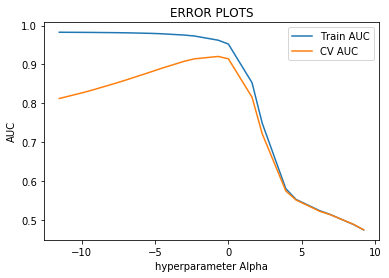

9
Best Alpha 0.5


In [79]:
NB_cv(set1_train,y_train,set1_cv,y_cv)

In [80]:
best_alpha_bow=0.5

auc for Test data is:: 0.9146583640299779


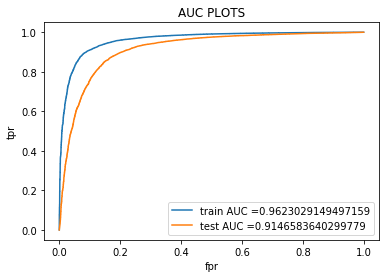

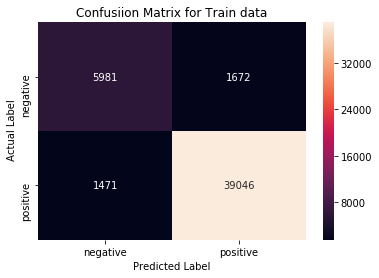

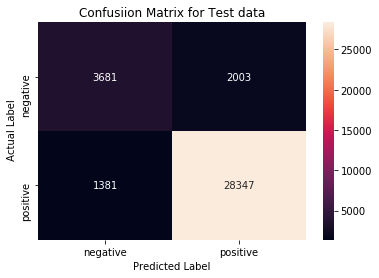

=======================For Negative Class ==========================
==================10 Most Important Features =======================
['zzzzzzzzzz' 'hexagon' 'heterocyclic' 'hestitationgerman' 'hestitate'
 'hesse' 'hesitations' 'saskatchewan' 'hesitating' 'hesitates']
==================10 Least Important Features ======================
['flavor' 'no' 'good' 'coffee' 'one' 'taste' 'product' 'would' 'like'
 'not']
=======================For Positive Class ==========================
==================10 Most Important Features =======================
['lifespan' 'suspiciously' 'clumsy' 'jest' 'suuuuuper' 'jesper'
 'jerkythat' 'suspension' 'jerks' 'jerkee']
==================10 Least Important Features ======================
['love' 'would' 'flavor' 'taste' 'coffee' 'one' 'great' 'good' 'like'
 'not']


In [83]:
auc_bow=NB_test(set1_train,y_train,set1_test,y_test,best_alpha_bow,I1)

# Applying Cross validation on Bow with added feature Review length

cv_auc [0.8127089315078591, 0.827724325635565, 0.8348624669019101, 0.8527752375453806, 0.860892674604442, 0.8806634323427648, 0.8895030495170184, 0.9082565075092688, 0.9144970572169304, 0.9205685808802748, 0.9145763201678259, 0.8160177757962842, 0.7222785605911118, 0.5752987139609186, 0.5521348811033424, 0.5231837503154309, 0.5148751909746234, 0.48959836849835436, 0.47562737760961676]
----------------------------------------------------------------------------------------------------
K [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
----------------------------------------------------------------------------------------------------


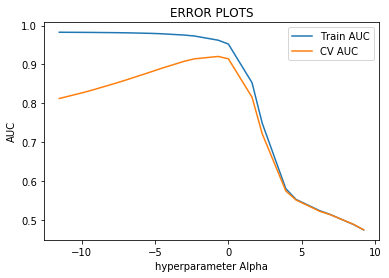

9
Best Alpha 0.5


In [84]:
NB_cv(set1_train_bow_rl,y_train,set1_cv_bow_rl,y_cv)

# Testing with BOW with added feature and Finding Most Important and Least important features

auc for Test data is:: 0.9145168481352677


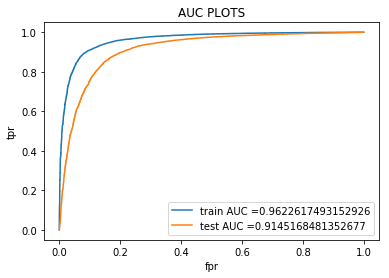

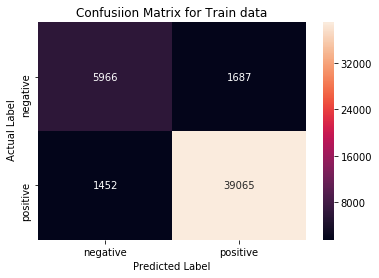

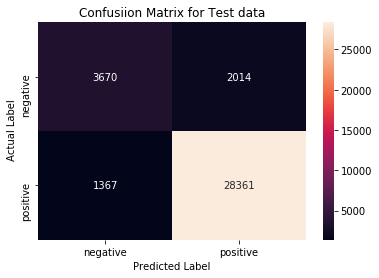

=======================For Negative Class ==========================
==================10 Most Important Features =======================
['lifespans' 'listning' 'listmania' 'transporting' 'listens' 'transports'
 'trapper' 'lish' 'liquour' 'liquorish']
==================10 Least Important Features ======================
['no' 'good' 'coffee' 'one' 'taste' 'product' 'would' 'like' 'not'
 'Rev_length']
=======================For Positive Class ==========================
==================10 Most Important Features =======================
['formulae' 'bezzera' 'readind' 'readingseveral' 'wounder' 'bevy'
 'suprized' 'oates' 'emits' 'reaing']
==================10 Least Important Features ======================
['would' 'flavor' 'taste' 'coffee' 'one' 'great' 'good' 'like' 'not'
 'Rev_length']


In [85]:
best_alpha_bow_rl=0.5
auc_bow_rl=NB_test(set1_train_bow_rl,y_train,set1_test_bow_rl,y_test,best_alpha_bow_rl,I2)

# [5.1] Applying Naive Bayes on  SET1 Bigram 

In [86]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bg = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect_bg.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (48170, 28595)
the number of unique words including both unigrams and bigrams  28595


In [87]:
# we use the fitted CountVectorizer to convert the text to vector
#.transform to apply on train, cv and test which will give set 1 of vectorized data
set1_bg_train = count_vect_bg.transform(X_train)
set1_bg_cv = count_vect_bg.transform(X_cv)
set1_bg_test = count_vect_bg.transform(X_test)

print("After vectorizations")
print(set1_bg_train.shape, y_train.shape)
print(set1_bg_cv.shape, y_cv.shape)
print(set1_bg_test.shape, y_test.shape)
print("="*100)

After vectorizations
(48170, 28595) (48170,)
(23727, 28595) (23727,)
(35412, 28595) (35412,)


In [88]:
I3=[]# will store name of features without addning Review Length
I4=[]# Will store name of features including Review length 
I3.extend(count_vect_bg.get_feature_names())
I4.extend(count_vect_bg.get_feature_names())
I4.append("Rev_length")
print(len(I3))
print(len(I4))
#print(I)

28595
28596


In [89]:
from scipy import sparse
from scipy.sparse import csr_matrix,coo_matrix, hstack
#review length is calculated for train cv and tset datasets
set1_bg_train_revlen=csr_matrix(set1_bg_train.sum(axis=1))
set1_bg_cv_revlen=csr_matrix(set1_bg_cv.sum(axis=1))
set1_bg_test_revlen=csr_matrix(set1_bg_test.sum(axis=1))

#To check dimension of newly created feature i.e. Review Length
print(set1_bg_train_revlen.get_shape())
print(set1_bg_cv_revlen.get_shape())
print(set1_bg_test_revlen.get_shape())

#Review length is stacked with bow features
set1_train_bg_rl=csr_matrix(hstack([set1_bg_train,set1_bg_train_revlen]))
set1_cv_bg_rl=csr_matrix(hstack([set1_bg_cv,set1_bg_cv_revlen]))
set1_test_bg_rl=csr_matrix(hstack([set1_bg_test,set1_bg_test_revlen]))

#dimensions of bow+rev length dataset are printed for check
print(set1_train_bg_rl.get_shape())
print(set1_cv_bg_rl.get_shape())
print(set1_test_bg_rl.get_shape())

(48170, 1)
(23727, 1)
(35412, 1)
(48170, 28596)
(23727, 28596)
(35412, 28596)


cv_auc [0.8127089315078591, 0.827724325635565, 0.8348624669019101, 0.8527752375453806, 0.860892674604442, 0.8806634323427648, 0.8895030495170184, 0.9082565075092688, 0.9144970572169304, 0.9205685808802748, 0.9145763201678259, 0.8160177757962842, 0.7222785605911118, 0.5752987139609186, 0.5521348811033424, 0.5231837503154309, 0.5148751909746234, 0.48959836849835436, 0.47562737760961676]
----------------------------------------------------------------------------------------------------
K [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
----------------------------------------------------------------------------------------------------


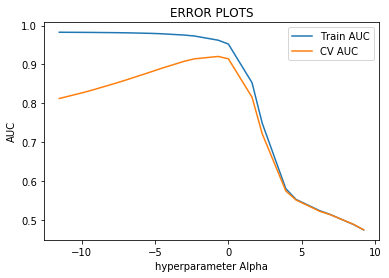

9
Best Alpha 0.5


In [90]:
NB_cv(set1_bg_train,y_train,set1_bg_cv,y_cv)

auc for Test data is:: 0.9413526914491532


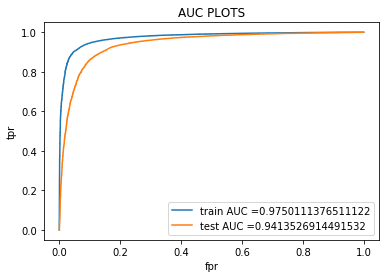

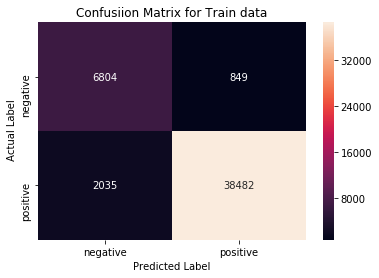

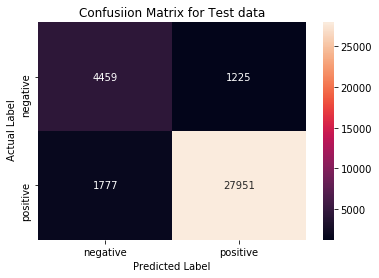

=======================For Negative Class ==========================
==================10 Most Important Features =======================
['good training' 'main course' 'extra boost' 'magnificent' 'small bites'
 'madras' 'extra treat' 'main thing' 'capers' 'capable']
==================10 Least Important Features ======================
['flavor' 'no' 'good' 'coffee' 'one' 'taste' 'product' 'would' 'like'
 'not']
=======================For Positive Class ==========================
==================10 Most Important Features =======================
['terrible product' 'sending back' 'false advertising' 'horrible taste'
 'negative stars' 'huge disappointment' 'money go' 'highly disappointed'
 'threw rest' 'dont waste']
==================10 Least Important Features ======================
['love' 'would' 'flavor' 'taste' 'coffee' 'one' 'great' 'good' 'like'
 'not']


In [91]:
best_alpha_bg=0.5
auc_bg=NB_test(set1_bg_train,y_train,set1_bg_test,y_test,best_alpha_bg,I3)

cv_auc [0.8127089315078591, 0.827724325635565, 0.8348624669019101, 0.8527752375453806, 0.860892674604442, 0.8806634323427648, 0.8895030495170184, 0.9082565075092688, 0.9144970572169304, 0.9205685808802748, 0.9145763201678259, 0.8160177757962842, 0.7222785605911118, 0.5752987139609186, 0.5521348811033424, 0.5231837503154309, 0.5148751909746234, 0.48959836849835436, 0.47562737760961676]
----------------------------------------------------------------------------------------------------
K [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
----------------------------------------------------------------------------------------------------


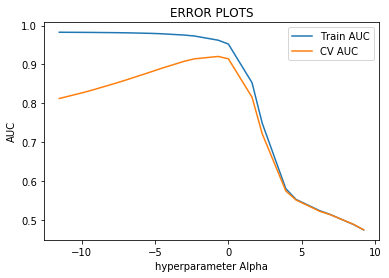

9
Best Alpha 0.5


In [92]:
NB_cv(set1_train_bg_rl,y_train,set1_cv_bg_rl,y_cv)

auc for Test data is:: 0.9413400534065748


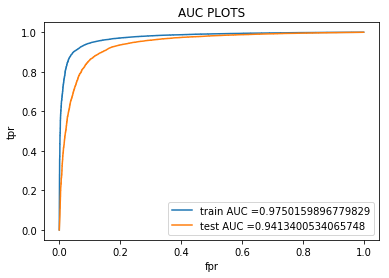

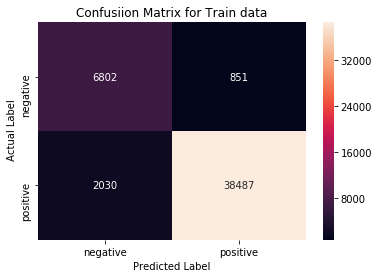

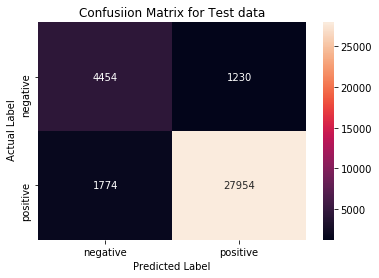

=======================For Negative Class ==========================
==================10 Most Important Features =======================
['dog many' 'product perfect' 'product plan' 'favorite coconut'
 'cracker crust' 'shipping well' 'bring boil' 'product problem'
 'bring work' 'product quickly']
==================10 Least Important Features ======================
['no' 'good' 'coffee' 'one' 'taste' 'product' 'would' 'like' 'not'
 'Rev_length']
=======================For Positive Class ==========================
==================10 Most Important Features =======================
['false advertising' 'terrible product' 'worst coffee' 'could return'
 'tasted awful' 'sending back' 'threw rest' 'highly disappointed'
 'extremely disappointed' 'usually love']
==================10 Least Important Features ======================
['would' 'flavor' 'taste' 'coffee' 'one' 'great' 'good' 'like' 'not'
 'Rev_length']


In [93]:
best_alpha_bg_rl=0.5
auc_bg_rl=NB_test(set1_train_bg_rl,y_train,set1_test_bg_rl,y_test,best_alpha_bg_rl,I4)

# [5.2] Applying Naive Bayes on TFIDF, SET 2

In [94]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

set2_train= tf_idf_vect.transform(X_train)
set2_cv = tf_idf_vect.transform(X_cv)
set2_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(set2_train))
print("the shape of out text TFIDF vectorizer ",set2_train.get_shape())

print(set2_cv.shape, y_cv.shape)
print(set2_test.shape, y_test.shape)
print("the number of unique words including both unigrams and bigrams ", set2_train.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (48170, 28595)
(23727, 28595) (23727,)
(35412, 28595) (35412,)
the number of unique words including both unigrams and bigrams  28595


In [ ]:
.fit is applied on tain wheras .tranform applied on train,cv,and test datasests

In [95]:
# we use the fitted CountVectorizer to convert the text to vector
#.transform to apply on train, cv and test which will give set 1 of vectorized data
set2_train = tf_idf_vect.transform(X_train)
set2_cv = tf_idf_vect.transform(X_cv)
set2_test = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(set2_train.shape, y_train.shape)
print(set2_cv.shape, y_cv.shape)
print(set2_test.shape, y_test.shape)
print("="*100)

After vectorizations
(48170, 28595) (48170,)
(23727, 28595) (23727,)
(35412, 28595) (35412,)


In [ ]:
#To add dimension in original TfIdf dataset

In [96]:
from scipy import sparse
from scipy.sparse import csr_matrix,coo_matrix, hstack
#review length is calculated for train cv and tset datasets
set2_train_revlen=csr_matrix(set2_train.sum(axis=1))
set2_cv_revlen=csr_matrix(set2_cv.sum(axis=1))
set2_test_revlen=csr_matrix(set2_test.sum(axis=1))

#To check dimension of newly created feature i.e. Review Length
print(set2_train_revlen.get_shape())
print(set2_cv_revlen.get_shape())
print(set2_test_revlen.get_shape())

#Review length is stacked with bow features
set2_train_rl=csr_matrix(hstack([set2_train,set2_train_revlen]))
set2_cv_rl=csr_matrix(hstack([set2_cv,set2_cv_revlen]))
set2_test_rl=csr_matrix(hstack([set2_test,set2_test_revlen]))

#dimensions of bow+rev length dataset are printed for check
print(set2_train_rl.get_shape())
print(set2_cv_rl.get_shape())
print(set2_test_rl.get_shape())

(48170, 1)
(23727, 1)
(35412, 1)
(48170, 28596)
(23727, 28596)
(35412, 28596)


In [ ]:
#Lists I5 and I6 are created to store tfidf and tfidf with review lenghth featue

In [97]:
I5=[]
I6=[]
I5.extend(tf_idf_vect.get_feature_names())
I6.extend(tf_idf_vect.get_feature_names())
I6.append("Rev_length")
print(len(I5))
print(len(I6))
#print(I)

28595
28596


cv_auc [0.8127089315078591, 0.827724325635565, 0.8348624669019101, 0.8527752375453806, 0.860892674604442, 0.8806634323427648, 0.8895030495170184, 0.9082565075092688, 0.9144970572169304, 0.9205685808802748, 0.9145763201678259, 0.8160177757962842, 0.7222785605911118, 0.5752987139609186, 0.5521348811033424, 0.5231837503154309, 0.5148751909746234, 0.48959836849835436, 0.47562737760961676]
----------------------------------------------------------------------------------------------------
K [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
----------------------------------------------------------------------------------------------------


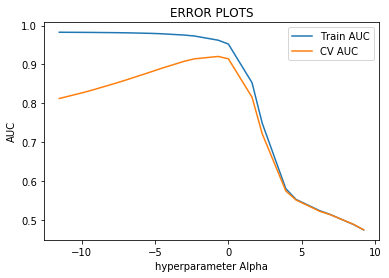

9
Best Alpha 0.5


In [98]:
NB_cv(set2_train,y_train,set2_cv,y_cv)


In [ ]:
#test is applied on set2 (tfidf dataset with only Review Text Features I5)

auc for Test data is:: 0.952319911414512


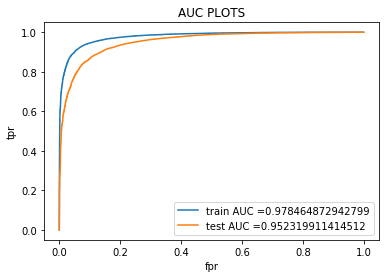

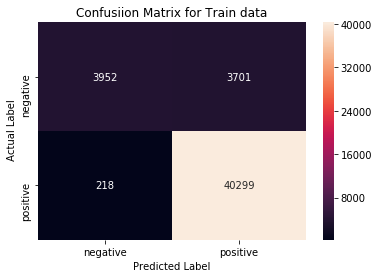

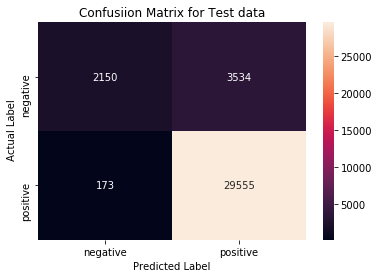

=======================For Negative Class ==========================
==================10 Most Important Features =======================
['cavalier king' 'pretty cool' 'great mixed' 'preservatives no'
 'preservatives chemicals' 'busy day' 'preservatives artificial'
 'great morning' 'butter add' 'butter also']
==================10 Least Important Features ======================
['even' 'flavor' 'no' 'one' 'coffee' 'would' 'taste' 'product' 'like'
 'not']
=======================For Positive Class ==========================
==================10 Most Important Features =======================
['usually love' 'worst coffee' 'threw rest' 'tasted awful'
 'highly disappointed' 'terrible product' 'money go' 'horrible taste'
 'sending back' 'dont waste']
==================10 Least Important Features ======================
['product' 'taste' 'one' 'tea' 'love' 'coffee' 'like' 'good' 'great' 'not']


In [99]:

best_alpha_tfidf=0.5

auc_tfidf=NB_test(set2_train,y_train,set2_test,y_test,best_alpha_tfidf,I5)

cv_auc [0.8127089315078591, 0.827724325635565, 0.8348624669019101, 0.8527752375453806, 0.860892674604442, 0.8806634323427648, 0.8895030495170184, 0.9082565075092688, 0.9144970572169304, 0.9205685808802748, 0.9145763201678259, 0.8160177757962842, 0.7222785605911118, 0.5752987139609186, 0.5521348811033424, 0.5231837503154309, 0.5148751909746234, 0.48959836849835436, 0.47562737760961676]
----------------------------------------------------------------------------------------------------
K [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
----------------------------------------------------------------------------------------------------


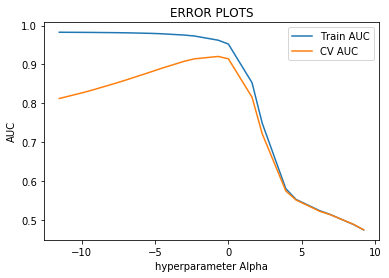

9
Best Alpha 0.5


In [100]:
NB_cv(set2_train_rl,y_train,set2_cv_rl,y_cv)


auc for Test data is:: 0.9524343195808073


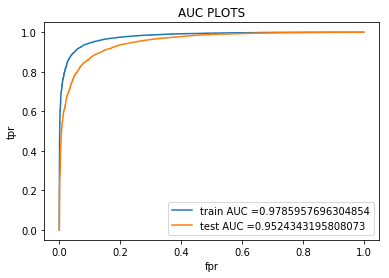

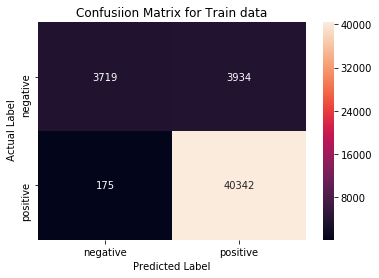

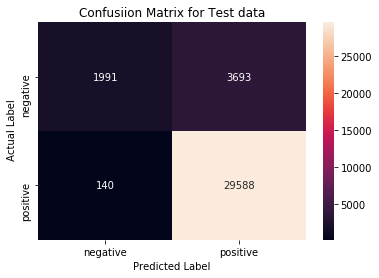

=======================For Negative Class ==========================
==================10 Most Important Features =======================
['definitely tell' 'definitely favorite' 'definitely continue'
 'definitely buying' 'definitely best' 'definately recommend'
 'definately order' 'online since' 'sugar cream' 'open pouch']
==================10 Least Important Features ======================
['flavor' 'no' 'one' 'coffee' 'would' 'taste' 'product' 'like' 'not'
 'Rev_length']
=======================For Positive Class ==========================
==================10 Most Important Features =======================
['money go' 'sending back' 'horrible taste' 'major disappointment'
 'terrible product' 'could return' 'extremely disappointed' 'usually love'
 'tasted awful' 'dont waste']
==================10 Least Important Features ======================
['taste' 'one' 'tea' 'love' 'coffee' 'like' 'good' 'great' 'not'
 'Rev_length']


In [101]:

best_alpha_tfidf_rl=0.5

auc_tfidf_rl=NB_test(set2_train_rl,y_train,set2_test_rl,y_test,best_alpha_tfidf_rl,I6)

In [103]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
result=PrettyTable()
result.field_names=["Vectorizer","dataset","Hyperparameter","AUC"]
result.add_row(["BoW","set1",best_alpha_bow,auc_bow])
result.add_row(["BiGram","set1",best_alpha_bg,auc_bg])
result.add_row(["TfIdf","set2",best_alpha_tfidf,auc_tfidf])

result.add_row(["BoW","set1 with RevLen ",best_alpha_bow_rl,auc_bow_rl])
result.add_row(["BiGram","set1 with RevLen",best_alpha_bg_rl,auc_bg_rl])
result.add_row(["TfIdf","set2 with RevLen",best_alpha_tfidf_rl,auc_tfidf_rl])



print(result)

+------------+-------------------+----------------+--------------------+
| Vectorizer |      dataset      | Hyperparameter |        AUC         |
+------------+-------------------+----------------+--------------------+
|    BoW     |        set1       |      0.5       | 0.9146583640299779 |
|   BiGram   |        set1       |      0.5       | 0.9413526914491532 |
|   TfIdf    |        set2       |      0.5       | 0.952319911414512  |
|    BoW     | set1 with RevLen  |      0.5       | 0.9145168481352677 |
|   BiGram   |  set1 with RevLen |      0.5       | 0.9413400534065748 |
|   TfIdf    |  set2 with RevLen |      0.5       | 0.9524343195808073 |
+------------+-------------------+----------------+--------------------+



#Hyperparameter Alpha is found 0.5 in all cases
# Best performance if shown on tfidf vectorized data and low performance is shown on BoW vectorized data

# Adding Review length as feature is not showing any significant change on model performance. Even Rev_length is least important feature in all cases and for both i.e. positive and negative classes
